In [1]:
import pandas as pd
import cv2
import numpy as np

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
folder='/notebooks/udacity/car_data/data/'

In [3]:


def load(csv, correction,folder):
    df=pd.read_csv(folder+csv, skiprows=1,\
            names=['center','left','right','steering','trottle','brake','speed'])
    
    #df=df[(df.steering>0.001) | (df.steering<-0.001)]
    
    df['center']=df.center.apply(lambda x:x.split('/')[-1])
    df['left']=df.left.apply(lambda x:x.split('/')[-1])
    df['right']=df.right.apply(lambda x:x.split('/')[-1])

    images=np.empty((len(df)*6,160,320,3), dtype=np.uint8)
    target=np.empty((len(df))*6, dtype=np.float)

    #center
    for i,fname in enumerate(df['center'].values):
        images[i]=cv2.imread(folder+'IMG/'+fname.strip())

    #left
    for i,fname in enumerate(df['left'].values):
        images[i+len(df)]=cv2.imread(folder+'IMG/'+fname.strip())

    #right
    for i,fname in enumerate(df['right'].values):
        images[i+2*len(df)]=cv2.imread(folder+'IMG/'+fname.strip())

    target[0:len(df)]=df.steering.values
    target[len(df):2*len(df)]=df.steering.values+correction
    target[2*len(df):3*len(df)]=df.steering.values-correction

    target[3*len(df):6*len(df)]=-target[0:3*len(df)]

    for i in range(len(df)*3):
        images[i+3*len(df)]=np.fliplr(images[i])
        
    return images, target


In [4]:
X1, y1= load('driving_log.csv', 0.2,'/notebooks/udacity/car_data/data/')

In [5]:
X2, y2= load('driving_log.csv', 0.2,'/notebooks/udacity/car_data/udacity_images/')

In [6]:
q=np.array([[0.299,0.587,0.114],\
           [-0.14713, -0.28886,0.436],\
           [0.612, -0.51499, -0.10001]])

def preproccess_image(image):
    return (np.dot(image,q.T)+[-128,0,0])/2

In [7]:
X=np.concatenate([X1,X2])
y=np.concatenate([y1,y2])


In [8]:
from keras.models import Sequential
from keras.layers import Flatten,Dense, Convolution2D, Activation, \
MaxPooling2D, Lambda,Conv2D,Dropout, Cropping2D

Using TensorFlow backend.


In [9]:
from keras.layers.normalization import BatchNormalization

In [10]:
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint
history = History()

tb=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

image=cv2.imread('/notebooks/data/IMG/center_2016_12_01_13_30_48_287.jpg')

tmp=rgb2yuv(image)

In [11]:
model=Sequential()

model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(BatchNormalization())
#model.add(Lambda(lambda x: (x / 255.0) - 0.5))

#model.add(Convolution2D(20, 5, 5, border_mode="same",
#input_shape=(160,320,3)))

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(160,320,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

In [12]:
model.compile(loss='mse',optimizer='adam', metrics=['mean_squared_error'])


In [ ]:
y

array([ 0. ,  0. ,  0. , ...,  0.2, -0. ,  0.2])

In [ ]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.0001, patience=4,
                            verbose=1, mode='min')



model.fit(X, y, \
          validation_split=0.2, shuffle=True, epochs=100,batch_size=128,\
         callbacks=[history, tb,checkpoint, early_stop, checkpoint])

Train on 74035 samples, validate on 18509 samples
Epoch 1/100
73984/74035 [============================>.] - ETA: 0s - loss: 7.7520 - mean_squared_error: 7.7520        

In [ ]:
with open("model.json", 'w') as outfile:
        outfile.write(model.to_json())

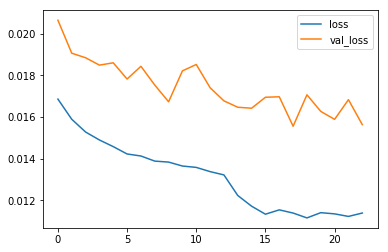

0.0155509777583 21


In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history.history['loss'][4:], label='loss')
plt.plot(history.history['val_loss'][4:], label='val_loss')

plt.legend()
plt.show()

print (min(history.history['val_loss']), np.argmin(history.history['val_loss']))

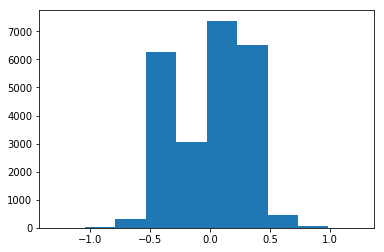

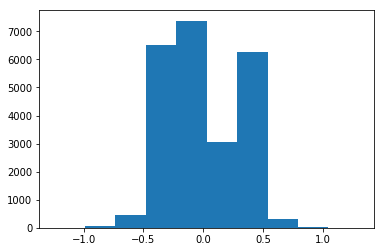

In [28]:
plt.hist(y2[24108:])
plt.show()

plt.hist(y2[:24108])
plt.show()

In [32]:
X2[0][0][0],X2[24108][0][-1]

(array([208, 163, 130], dtype=uint8), array([208, 163, 130], dtype=uint8))